In [2]:
import mlflow
import os

mlflow.set_tracking_uri("http://localhost:5000")
os.environ['AWS_ACCESS_KEY_ID'] = 'mlflow'  
os.environ['AWS_SECRET_ACCESS_KEY'] = 'mlflowpass' 

os.environ['MLFLOW_S3_ENDPOINT_URL'] = 'http://localhost:10000'

In [31]:
import sys
sys.path.append("../train")

from unet import UNet

unet_model = mlflow.pytorch.load_model("runs:/c5869905d70647b8ae137d6551688337/model")

model.eval()

UNet(
  (enc1): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
  )
  (enc2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
  )
  (enc3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_r

In [39]:
import os
from PIL import Image
import torch
import torch.nn.functional as F
from torchvision.transforms.functional import to_tensor


image_dir = "../train-classifier/chest_xray/test/PNEUMONIA/person3_virus_15.jpeg"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
original_image = Image.open(image_dir)
resized_image = original_image.convert("L").resize((256, 256))
img_tensor = to_tensor(resized_image).unsqueeze(0).to(device)

# 원본 이미지 크기 정의
H, W = original_image.size[1], original_image.size[0]  # PIL Image는 (width, height) 순서

with torch.no_grad():
    mask = model(img_tensor)

mask = F.interpolate(mask, size=(H, W), mode='bilinear', align_corners=False)
mask = (mask[0, 0] > 0.5).float()  # [H, W]


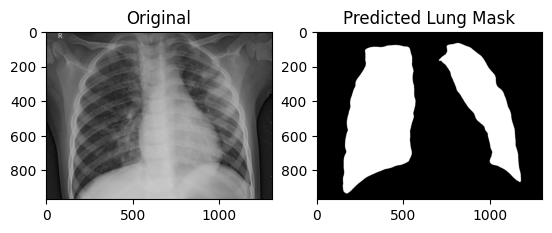

In [40]:
# 시각화

import matplotlib.pyplot as plt

plt.subplot(1, 2, 1)
plt.title("Original")
plt.imshow(original_image, cmap='gray')

plt.subplot(1, 2, 2)
plt.title("Predicted Lung Mask")
plt.imshow(mask.cpu(), cmap='gray')

plt.show()

In [41]:
resnet_model = mlflow.pytorch.load_model("runs:/6c979a4318e4436e95c3d4bbd437493b/model")

                                         

2025/08/07 05:44:21 WARNING mlflow.pytorch: Stored model version '2.1.0' does not match installed PyTorch version '2.7.1+cu126'


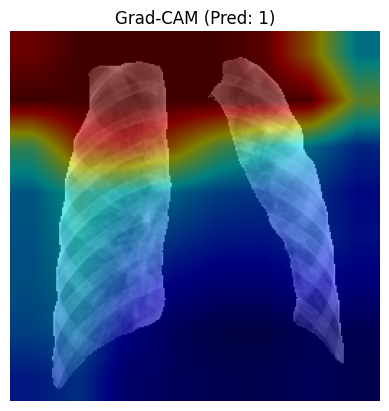

In [42]:
import torch
import torchvision.transforms.functional as TF
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import cv2

# 1. 이미지 전처리
original_image = original_image.convert("L").resize((256, 256))
image_tensor = TF.to_tensor(original_image).unsqueeze(0).to(device)  # [1, 1, H, W]

# 2. 마스크 추론 (U-Net)
with torch.no_grad():
    unet_output = unet_model(image_tensor)  # [1, 1, H, W]
    mask = (unet_output > 0.5).float()

# 3. 마스크 적용
masked_tensor = image_tensor * mask  # [1, 1, H, W]
masked_tensor = masked_tensor.repeat(1, 3, 1, 1)  # → [1, 3, H, W] for ResNet

# 4. Grad-CAM 준비
resnet_model.eval()
target_layer = resnet_model.layer4[-1]

# Hook 등록
activations = {}
gradients = {}

def forward_hook(module, input, output):
    activations["value"] = output.detach()

def backward_hook(module, grad_input, grad_output):
    gradients["value"] = grad_output[0].detach()

target_layer.register_forward_hook(forward_hook)
target_layer.register_backward_hook(backward_hook)

# 5. ResNet 추론 + Grad-CAM 계산
output = resnet_model(masked_tensor)
pred_class = torch.argmax(output, dim=1).item()

# Backprop
resnet_model.zero_grad()
output[0, pred_class].backward()

# 6. Grad-CAM 계산
activation = activations["value"][0]        # [C, H, W]
gradient = gradients["value"][0]            # [C, H, W]
weights = torch.mean(gradient, dim=(1, 2))  # [C]

cam = torch.zeros_like(activation[0])
for i, w in enumerate(weights):
    cam += w * activation[i]

cam = F.relu(cam)
cam -= cam.min()
cam /= cam.max()
cam_np = cam.cpu().numpy()

# 7. 시각화
img_np = masked_tensor.squeeze().permute(1, 2, 0).cpu().numpy()
img_np = (img_np - img_np.min()) / (img_np.max() - img_np.min())

cam_resized = cv2.resize(cam_np, (img_np.shape[1], img_np.shape[0]))
heatmap = cv2.applyColorMap(np.uint8(255 * cam_resized), cv2.COLORMAP_JET)
heatmap = np.float32(heatmap) / 255

overlay = 0.5 * img_np + 0.5 * heatmap

plt.imshow(overlay)
plt.title(f"Grad-CAM (Pred: {pred_class})")
plt.axis('off')
plt.show()


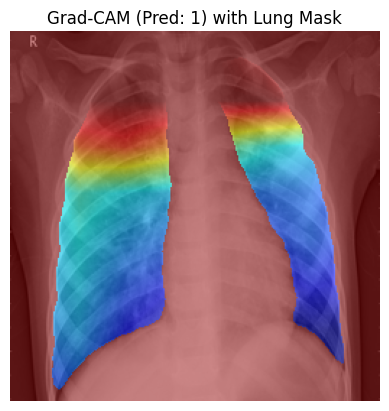

In [43]:
import torch
import torchvision.transforms.functional as TF
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import cv2

# 1. 이미지 전처리
original_image = original_image.convert("L").resize((256, 256))
image_tensor = TF.to_tensor(original_image).unsqueeze(0).to(device)  # [1, 1, H, W]

# 2. 마스크 추론 (U-Net)
with torch.no_grad():
    unet_output = unet_model(image_tensor)  # [1, 1, H, W]
    mask = (unet_output > 0.5).float()

# 3. 마스크 적용
masked_tensor = image_tensor * mask  # [1, 1, H, W]
masked_tensor = masked_tensor.repeat(1, 3, 1, 1)  # → [1, 3, H, W] for ResNet

# 4. Grad-CAM 준비
resnet_model.eval()
target_layer = resnet_model.layer4[-1]

activations = {}
gradients = {}

def forward_hook(module, input, output):
    activations["value"] = output.detach()

def backward_hook(module, grad_input, grad_output):
    gradients["value"] = grad_output[0].detach()

target_layer.register_forward_hook(forward_hook)
target_layer.register_backward_hook(backward_hook)

# 5. ResNet 추론 + Grad-CAM 계산
output = resnet_model(masked_tensor)
pred_class = torch.argmax(output, dim=1).item()

resnet_model.zero_grad()
output[0, pred_class].backward()

# 6. Grad-CAM 계산
activation = activations["value"][0]        # [C, H, W]
gradient = gradients["value"][0]            # [C, H, W]
weights = torch.mean(gradient, dim=(1, 2))  # [C]

cam = torch.zeros_like(activation[0])
for i, w in enumerate(weights):
    cam += w * activation[i]

cam = F.relu(cam)
cam -= cam.min()
cam /= cam.max()
cam_np = cam.cpu().numpy()

# 7. 마스크와 Grad-CAM 곱하기
mask_np = mask.squeeze().cpu().numpy()  # [H, W] = [256, 256]
cam_resized = cv2.resize(cam_np, (mask_np.shape[1], mask_np.shape[0]))  # [256, 256]
cam_masked = cam_resized * mask_np  # 같은 크기로 곱함

# 8. 시각화 (원본 이미지에 오버레이)
# 8. 시각화 (원본 이미지에 오버레이)
img_np = image_tensor.squeeze().cpu().numpy()  # [H, W] (grayscale)
img_np = np.stack([img_np]*3, axis=2)  # → [H, W, 3]

heatmap = cv2.applyColorMap(np.uint8(255 * cam_masked), cv2.COLORMAP_JET)
heatmap = np.float32(heatmap) / 255

overlay = 0.5 * (img_np / img_np.max()) + 0.5 * heatmap
overlay = overlay / overlay.max()

plt.imshow(overlay)
plt.title(f"Grad-CAM (Pred: {pred_class}) with Lung Mask")
plt.axis('off')
plt.show()
